In [1]:
# import libraries 
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import cv2
from scipy.optimize import dual_annealing
import os
import sys
from skimage.measure import regionprops
from skimage.filters import median, gaussian, threshold_local,threshold_minimum
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, relabel_sequential
from skimage.morphology import disk, label,area_opening,area_closing,binary_erosion
from scipy import ndimage
import xlsxwriter
from sklearn.cluster import KMeans, DBSCAN
import random
from coregistration_metrics import transform_image,mutual_information,crop_zeros,cleanup,plot,overlay_cells,stretch_contrast
from coregistration_metrics import visualize,get_connection_length,on_edge,edgeDistance,ClusterImage


# Stitching Tiles

In [4]:
n, d = 6, 8 # tiling dimentions
percent = 0.1 # percent overlap
tilename = "T00001C01Z001.tif"
tile0 = cv2.imread("../day 6 tiles/AP 3 (raw tile 8)/"+tilename, -1)
h, w = tile0.shape
overlap = int(w*percent)
mis = []
for shift in range(1,int(h/2)):
    tile1 = cv2.imread("../day 6 tiles/AP 3 (raw tile 7)/"+tilename, -1)
    common_region1 = tile1[:-shift,-overlap:]
    tile2 = cv2.imread("../day 6 tiles/AP 3 (raw tile 6)/"+tilename, -1)
    common_region2 = tile2[shift:,:overlap]
    hgram, _, _ = np.histogram2d(common_region1.ravel(),common_region2.ravel(),bins=20)
    pxy = hgram / float(np.sum(hgram))
    py = np.sum(pxy, axis=1) 
    px = np.sum(pxy, axis=0) 
    px_py = py[:, None] * px[None, :] 
    nzs = pxy > 0 
    mis.append(np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs])))
shift = np.argmax(mis)
shift_x = np.argmax(mis)+1
overlap_y = int(h*percent)
stitched = np.zeros((n*h,d*w))
x,y = 0,d*shift
for j in range(n):
    if j%2 == 0:
        stitched[y:y+h,x:x+w] = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str((j+1)*d)+")/"+tilename, -1)
        x += w-overlap
        for i in range(d,1,-1):
            y -= shift
            tile2 = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(i-1+j*d)+")/"+tilename, -1)
            stitched[y:y+h,x:x+overlap] = (stitched[y:y+h,x:x+overlap]+tile2[:,:overlap])/2
            if j == 0:
                stitched[y:y+h,x+overlap:x+w] = tile2[:,overlap:]
            else:
                stitched[y:y+overlap_y,x+overlap:x+w] = (stitched[y:y+overlap_y,x+overlap:x+w]+tile2[:overlap_y,overlap:])/2
                stitched[y+overlap_y:y+h,x+overlap:x+w] = tile2[overlap_y:,overlap:]
            x += w-overlap
        y += h-overlap_y+shift*(d-1)
        x = shift_x*(j+1)
    else:
        stitched[y:y+h,x:x+w] = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(j*d+1)+")/"+tilename, -1)
        x += w-overlap
        for i in range(d-1):
            y -= shift
            tile2 = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(1+j*d+i+1)+")/"+tilename, -1)
            stitched[y:y+h,x:x+overlap] = (stitched[y:y+h,x:x+overlap]+tile2[:,:overlap])/2
            if j == 0:
                stitched[y:y+h,x+overlap:x+w] = tile2[:,overlap:]
            else:
                stitched[y:y+overlap_y,x+overlap:x+w] = (stitched[y:y+overlap_y,x+overlap:x+w]+tile2[:overlap_y,overlap:])/2
                stitched[y+overlap_y:y+h,x+overlap:x+w] = tile2[overlap_y:,overlap:]
            x += w-overlap
        y += h-overlap_y+shift*(d-1)
        x = shift_x*(j+1)
    
top,bottom,left,right = crop_zeros(stitched)
dapi_full = stitched[top+shift*n:bottom-shift*n,left+shift_x*d:right-shift_x*d]
#cv2.imwrite("day6 stitched dapi.tif",stitched[top:bottom,left:right].astype(np.dtype('uint16')))


# Brightfield stitching

In [ ]:
for j in range(n):
    if j%2 == 0:
        stitched[y+overlap_y:y+h,x:x+w] = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str((j+1)*d)+")/"+tilename, -1)[overlap_y:,:]
        x += w-overlap
        for i in range(d,1,-1):
            y -= shift
            tile2 = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(i-1+j*d)+")/"+tilename, -1)
            stitched[y+overlap_y:y+h,x:x+w] = tile2[overlap_y:,:]
            x += w-overlap
        y += h-overlap_y+shift*(d-1)
        x = shift_x*(j+1)
    else:
        stitched[y+overlap_y:y+h,x:x+w] = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(j*d+1)+")/"+tilename, -1)[overlap_y:,:]
        x += w-overlap
        for i in range(d-1):
            y -= shift
            tile2 = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(1+j*d+i+1)+")/"+tilename, -1)
            stitched[y+overlap_y:y+h,x:x+w] = tile2[overlap_y:,:]
            x += w-overlap
        y += h-overlap_y+shift*(d-1)
        x = shift_x*(j+1)
    
top,bottom,left,right = crop_zeros(stitched)
cv2.imwrite("bright.tif",stitched[top:bottom,left:right].astype(np.dtype('uint16')))


# Segmentation

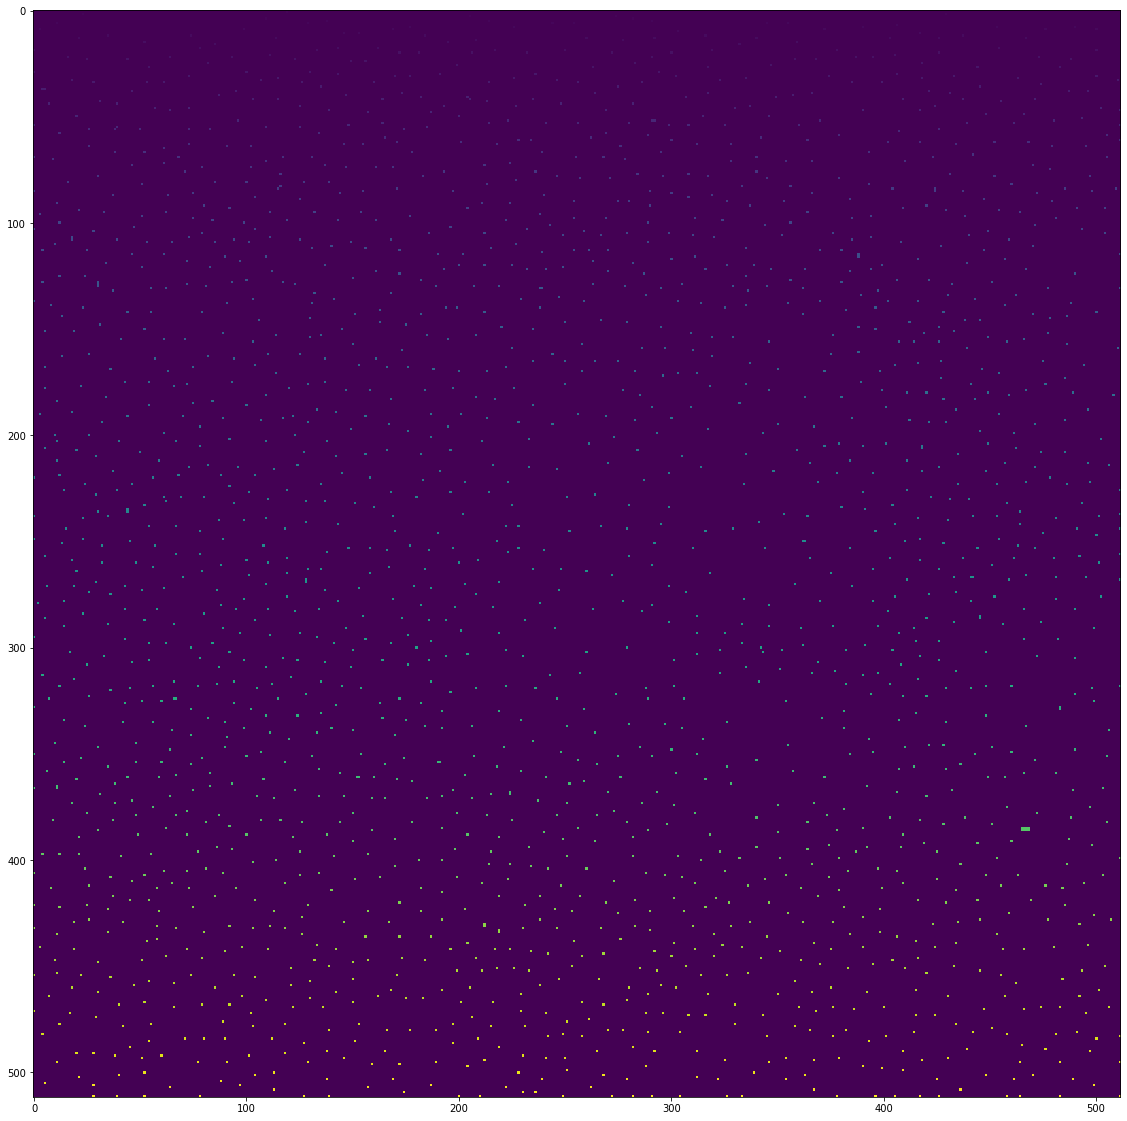

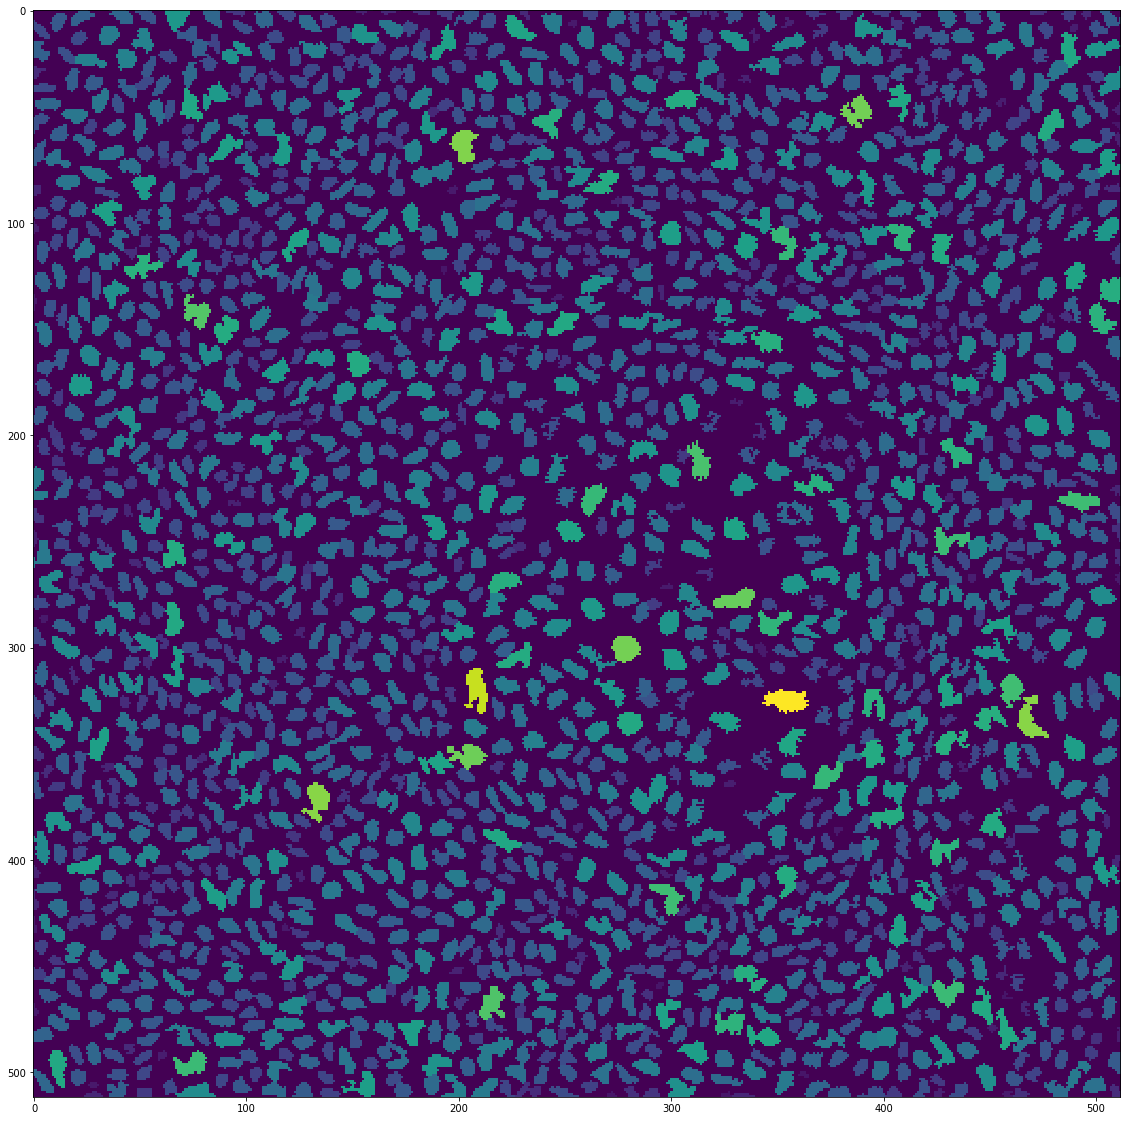

In [43]:
RadThr = 21
Thr = 1
DistanceBlurRad = 0.5
dapi = cv2.imread("../day 6 tiles/AP 3 (raw tile 27)/T00001C01Z001.tif", -1)
dapi_thresh = threshold_minimum(gaussian(dapi_full/np.max(dapi_full),sigma=10))
dapi_mask = gaussian(dapi,sigma=5)>dapi_thresh
dapi_mask = area_closing(dapi_mask,area_threshold=10000)
dapi_mask = area_opening(dapi_mask,area_threshold=400)

dapi = dapi/np.max(dapi)
dapi = 255*dapi
mask = threshold_local(dapi, RadThr, offset = -Thr).astype(np.uint8)
mask = dapi>mask
mask = dapi_mask&mask
mask = area_opening(mask,area_threshold=10)
mask = area_closing(mask,area_threshold=5)

distance = ndimage.distance_transform_edt(mask)
distance = gaussian(distance, sigma=DistanceBlurRad)   
local_maxi = peak_local_max(distance, indices=False,exclude_border=False, min_distance=4, labels=mask)
markers = label(local_maxi)
# Binary watershed
nuclei_labels = watershed(-distance, markers, mask=mask)
fig=plt.figure(figsize=(20,20))
plt.imshow(markers)
plt.show()
fig=plt.figure(figsize=(20,20))
plt.imshow(plot)
plt.show()

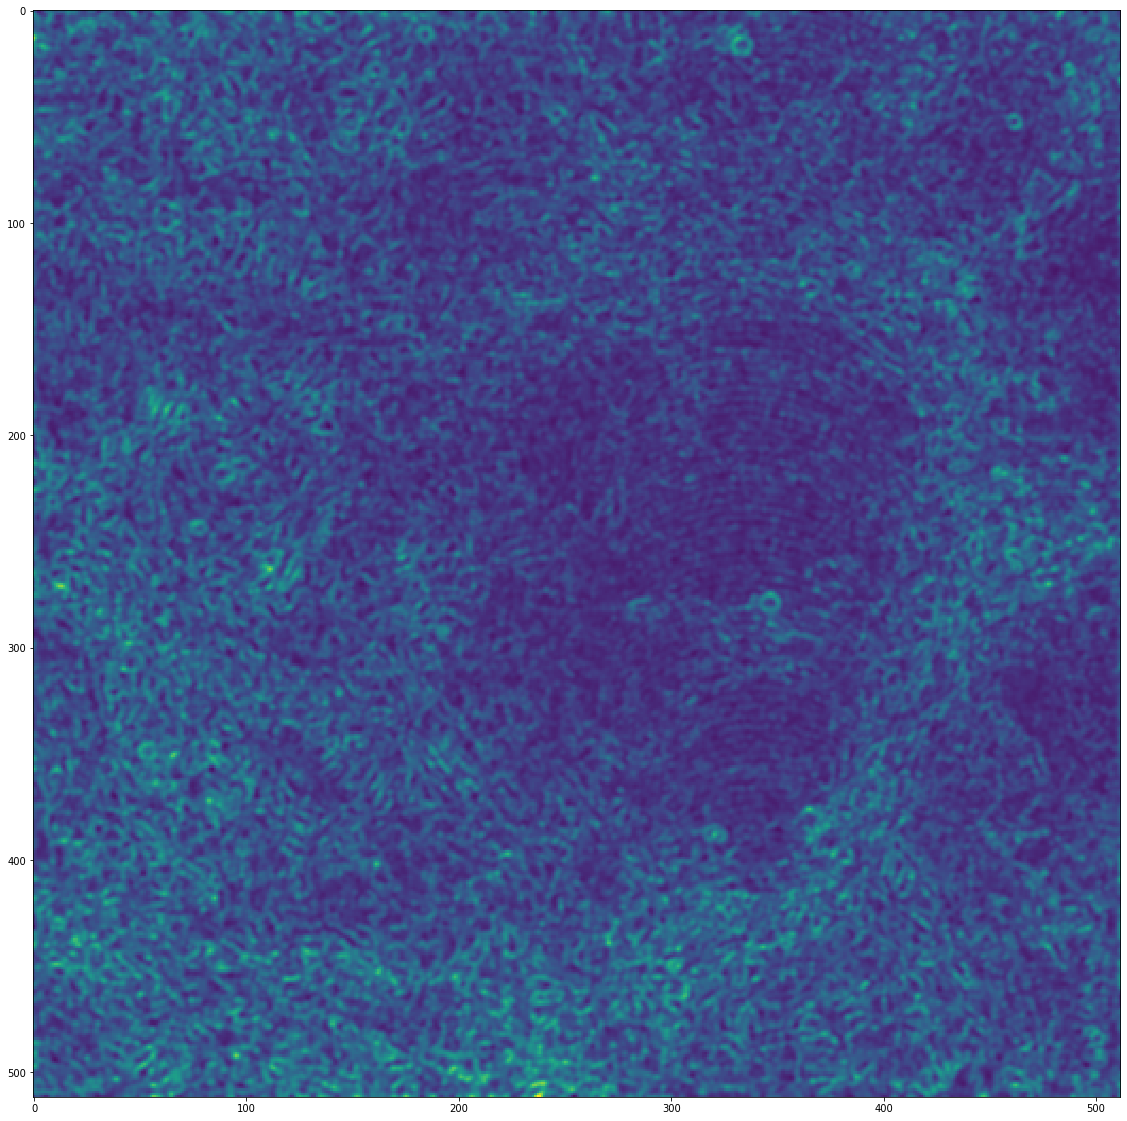

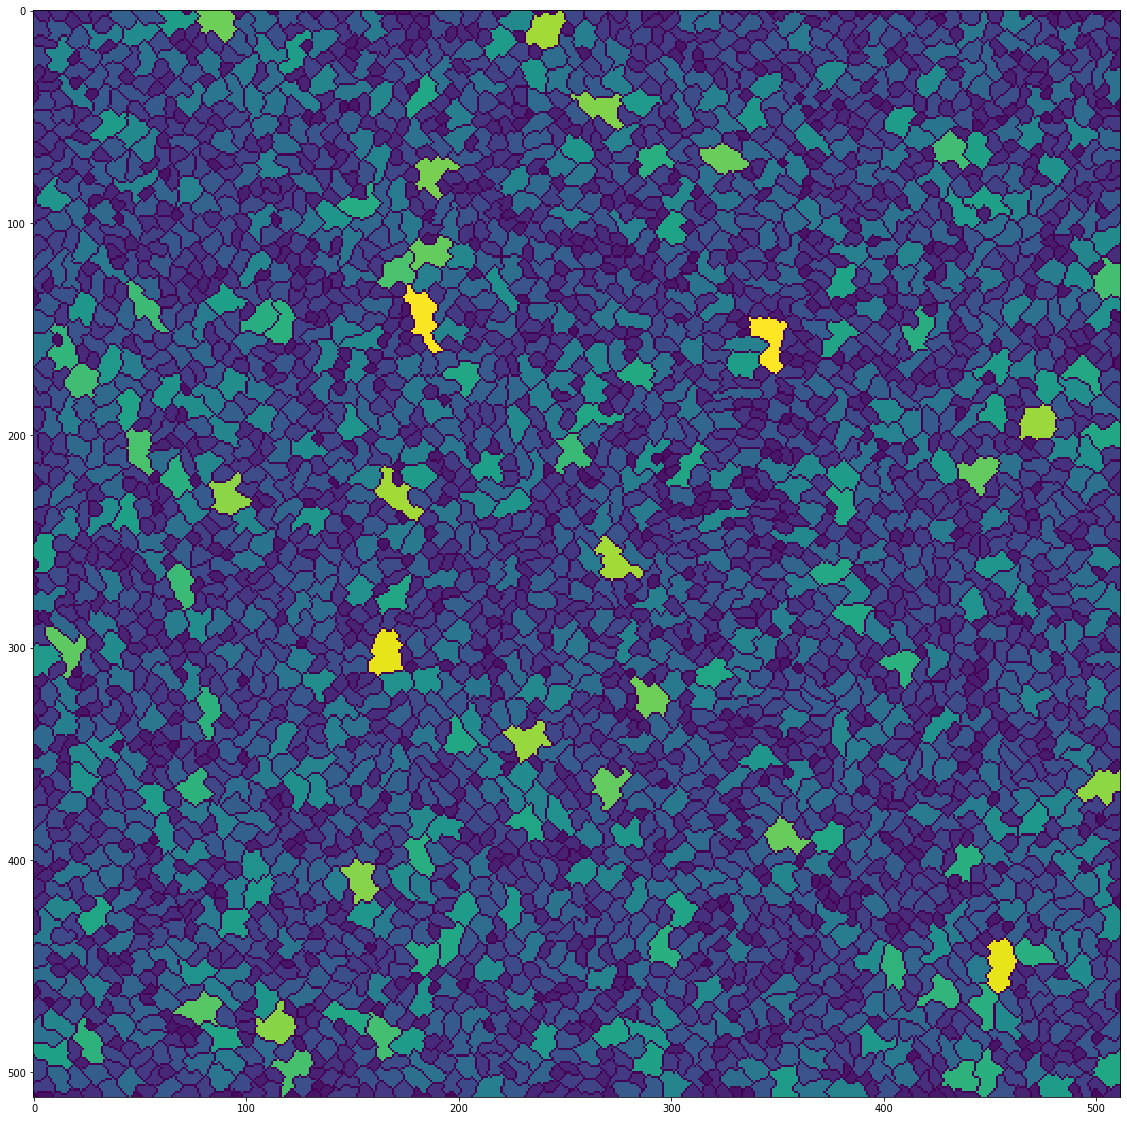

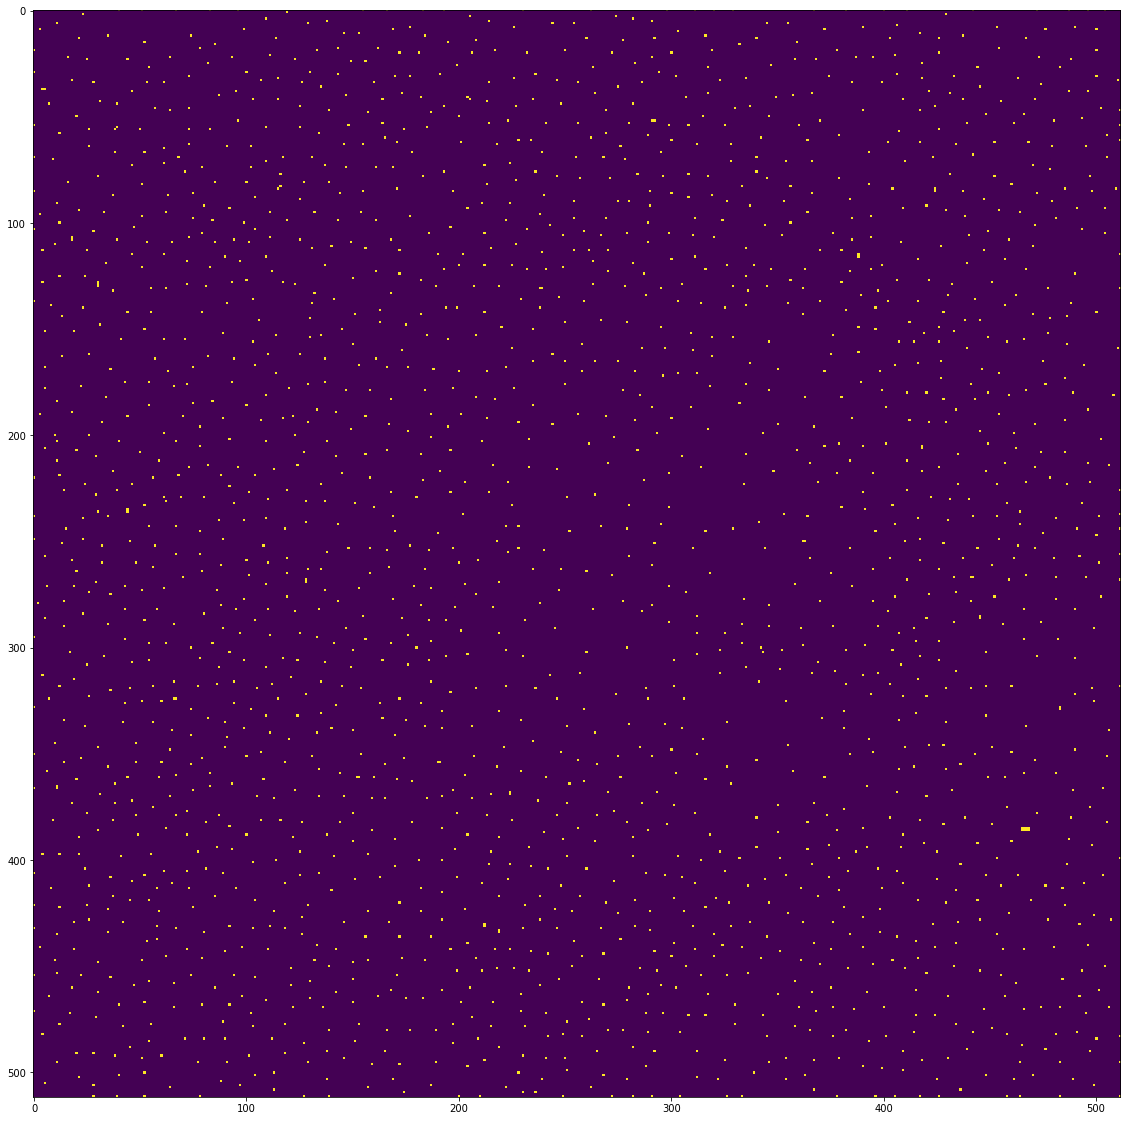

In [71]:
from skimage.morphology import dilation
bright = cv2.imread("../day 6 tiles/AP 3 (raw tile 27)/T00001C05Z001.tif", -1)
bright = bright/np.max(bright)
bright = 255*bright
bright2 = cv2.Laplacian(bright,cv2.CV_64F)
bright2 = dilation(bright2)
bright2 = gaussian(bright2)
#mask = threshold_local(bright2, RadThr, offset = -Thr).astype(np.uint8)
#mask = bright2>mask
local_maxi = peak_local_max(255-bright2, indices=False,exclude_border=False, min_distance=3)
cyto_markers = label(local_maxi)

cytoplasm_labels = watershed(bright2, cyto_markers,watershed_line=True,mask=dapi_mask)
cytoprops = regionprops(cytoplasm_labels) 
cells, X, Y, area, perimeter, eccentricity, plot = cleanup(cytoprops,dapi.shape[0],dapi.shape[1],".",5) 

fig=plt.figure(figsize=(20,20))
plt.imshow(bright2)
plt.show()
fig=plt.figure(figsize=(20,20))
plt.imshow(plot)
plt.show()
fig=plt.figure(figsize=(20,20))
plt.imshow(markers>0)
plt.show()
#cv2.imwrite("mask.tif",bright2)


In [51]:
cytos = regionprops(cyto_markers)
index = np.max(nuclei_labels)+1
nuclei_labels_copy = nuclei_labels
for i in range(len(cytos)):
    n = nuclei_labels[int(cytos[i].centroid[0]),int(cytos[i].centroid[1])]
    if n > 0:
        for x,y in cytoprops[i].coords:
            nuclei_labels_copy[x,y] = n
    else:
        for x,y in cytoprops[i].coords:
            nuclei_labels_copy[x,y] = index
        index += 1

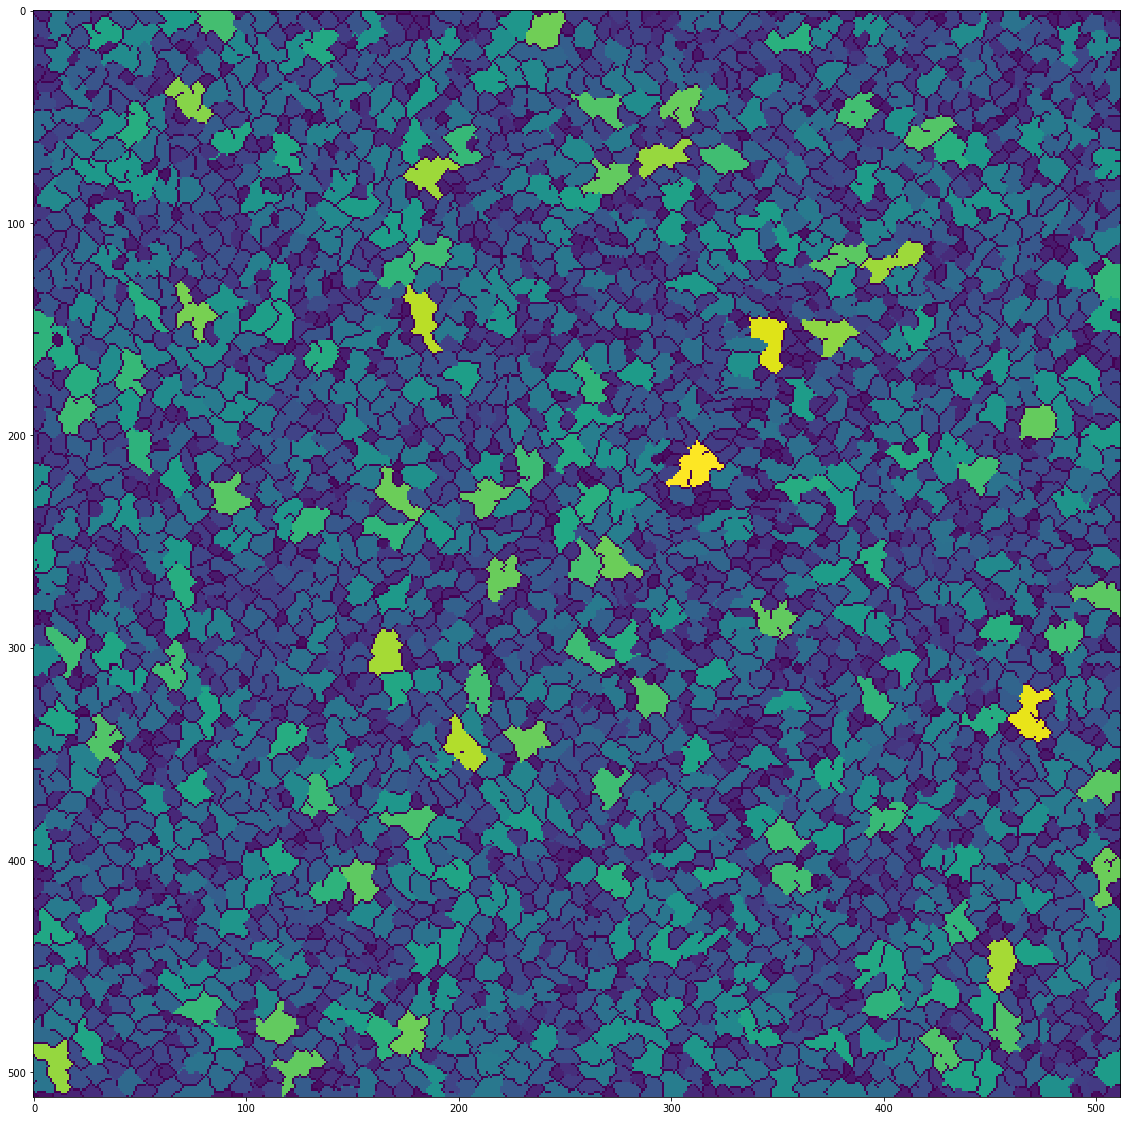

In [68]:
cellprops = regionprops(nuclei_labels_copy) 
cells, X, Y, area, perimeter, eccentricity, plot = cleanup(cellprops,dapi.shape[0],dapi.shape[1],".",5) 
fig=plt.figure(figsize=(20,20))
plt.imshow(plot)
plt.show()

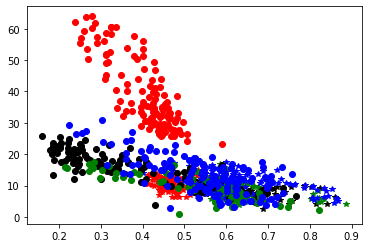

In [69]:
from skimage.feature import greycomatrix, greycoprops
mito = "T00001C01Z001.tif"
tiles0 = []
for j in range(1,122):
    m = cv2.imread("../day 0 tiles/AP 4 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles0.append(m.astype(np.uint8))
xs0 = []
ys0 = []
for patch in tiles0:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs0.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys0.append(greycoprops(glcm, 'correlation')[0, 0])

tiles1 = []
for j in range(1,122):
    m = cv2.imread("../day 1 tiles/AP 3 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles1.append(m.astype(np.uint8))
xs1 = []
ys1 = []
for patch in tiles1:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs1.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys1.append(greycoprops(glcm, 'correlation')[0, 0])
    
tiles2 = []
for j in range(1,122):
    m = cv2.imread("../day 2 tiles/AP 2 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles2.append(m.astype(np.uint8))
xs2 = []
ys2 = []
for patch in tiles2:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs2.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys2.append(greycoprops(glcm, 'correlation')[0, 0])
    
tiles3 = []
for j in range(1,122):
    m = cv2.imread("../day 3 tiles/AP (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles3.append(m.astype(np.uint8))
xs3 = []
ys3 = []
for patch in tiles3:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs3.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys3.append(greycoprops(glcm, 'correlation')[0, 0])
    
tiles4 = []
for j in range(1,122):
    m = cv2.imread("../day 4 tiles/AP (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles4.append(m.astype(np.uint8))
    
xs4 = []
ys4 = []
for patch in tiles4:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs4.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys4.append(greycoprops(glcm, 'correlation')[0, 0])
tiles5 = []
for j in range(1,113):
    m = cv2.imread("../day 5 tiles/AP 2 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles5.append(m.astype(np.uint8))
    
xs5 = []
ys5 = []
for patch in tiles5:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs5.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys5.append(greycoprops(glcm, 'correlation')[0, 0])
tiles6 = []
for j in range(1,49):
    m = cv2.imread("../day 6 tiles/AP 3 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles6.append(m.astype(np.uint8))
    
xs6 = []
ys6 = []
for patch in tiles6:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs6.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys6.append(greycoprops(glcm, 'correlation')[0, 0])

tiles7 = []
for j in range(1,127):
    m = cv2.imread("../day 7 tiles/AP 5 (raw tile "+str(j)+")/"+mito, -1)
    m = m/np.max(m)
    m = 255*m
    tiles7.append(m.astype(np.uint8))
    
xs7 = []
ys7 = []
for patch in tiles7:
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs7.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys7.append(greycoprops(glcm, 'correlation')[0, 0])

plt.plot(ys0,xs0,'r*',ys1,xs1,'k*',ys2,xs2,'g*',ys3,xs3,'b*',ys4,xs4,'ro',ys5,xs5,'ko',ys6,xs6,'go',ys7,xs7,'bo')
plt.show()
